[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK 'punkt' ve 'stopwords' kaynakları indiriliyor/kontrol ediliyor...
NLTK kaynakları hazır.
Gerekli kütüphaneler içe aktarıldı.

TensorFlow Datasets (TFDS) ile IMDb veri seti yükleniyor...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IMRXS_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IMRXS_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IMRXS_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
IMDb veri seti yüklendi! (Süre: 37.86 saniye)
Eğitim seti örnek sayısı: 25000
Test seti örnek sayısı: 25000

Veri setini DataFrame'e dönüştürme...
DataFrame'ler oluşturuldu. (Süre: 22.63 saniye)

Metin ön işleme başlıyor (Bu işlem biraz zaman alabilir)...
Metin ön işleme tamamlandı. (Süre: 52.10 saniye)

TF-IDF Vektörleştirme işlemi başlıyor...
TF-IDF Vektörleştirme tamamlandı. (Süre: 21.47 saniye)
Eğitim verisi TF-IDF matris boyutu: (25000, 10000)
Test verisi TF-IDF matris boyutu: (25000, 10000)

Baseline Model (Logistic Regression) eğitimi başlıyor...
Baseline Model eğitimi tamamlandı. (Süre: 1.77 saniye)

Baseline Model test verisi üzerinde değerlendiriliyor...
Tahminler yapıldı. (Süre: 0.01 saniye)

--- Baseline Model (TF-IDF + Logistic Regression) Sonuçları ---
Doğruluk (Accuracy): 0.8866

Sınıflandırma Raporu:
              precision    r

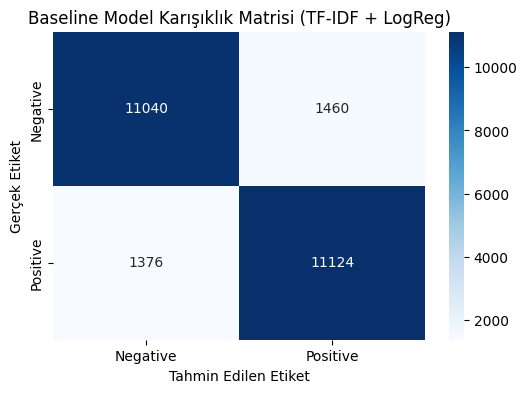


Baseline model (TF-IDF) adımları tamamlandı.
Sonraki adım: Word Embedding kullanarak çözüm.


In [3]:
# Gerekli Kütüphanelerin İçe Aktarılması
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import re  # Regular expressions for cleaning text
import nltk
nltk.download('punkt_tab')
import time # Zaman ölçümü için

# --- NLTK Kaynaklarını İndir ---
# word_tokenize ve stopwords için gerekli kaynakları başta indirelim
try:
    print("NLTK 'punkt' ve 'stopwords' kaynakları indiriliyor/kontrol ediliyor...")
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK kaynakları hazır.")
except Exception as e:
    print(f"NLTK kaynakları indirilirken bir hata oluştu: {e}")
    print("Devam etmeden önce bu hatayı çözmelisiniz.")
    exit() # Hata varsa devam etme

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn kütüphaneleri
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC # Alternatif olarak SVM de kullanılabilir
from sklearn.naive_bayes import MultinomialNB # Başka bir alternatif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt # Confusion matrix görselleştirmesi için
import seaborn as sns # Confusion matrix görselleştirmesi için

print("Gerekli kütüphaneler içe aktarıldı.")

# --- Adım 1: Veri Setini Yükleme ---
print("\nTensorFlow Datasets (TFDS) ile IMDb veri seti yükleniyor...")
start_time = time.time()
try:
    (ds_train, ds_test), ds_info = tfds.load(
        'imdb_reviews',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
    print(f"IMDb veri seti yüklendi! (Süre: {time.time() - start_time:.2f} saniye)")
    print(f"Eğitim seti örnek sayısı: {ds_info.splits['train'].num_examples}")
    print(f"Test seti örnek sayısı: {ds_info.splits['test'].num_examples}")

except Exception as e:
    print(f"\nVeri seti yüklenirken bir hata oluştu: {e}")
    exit()

# --- Adım 2.1 (Başlangıç): Veriyi Listelere/DataFrame'e Dönüştürme ---
print("\nVeri setini DataFrame'e dönüştürme...")
start_time = time.time()
train_reviews = []
train_labels = []
test_reviews = []
test_labels = []

# TFDS veri setini dolaşma
for review, label in ds_train:
    train_reviews.append(review.numpy().decode('utf-8'))
    train_labels.append(label.numpy())
for review, label in ds_test:
    test_reviews.append(review.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

df_train = pd.DataFrame({'review': train_reviews, 'label': train_labels})
df_test = pd.DataFrame({'review': test_reviews, 'label': test_labels})
print(f"DataFrame'ler oluşturuldu. (Süre: {time.time() - start_time:.2f} saniye)")

# --- Adım 2.1 (Devamı): Metin Ön İşleme ---

# İngilizce stop words listesi (NLTK indirildikten sonra tanımla)
stop_words = set(stopwords.words('english'))

# Ön işleme fonksiyonu
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text) # HTML tags
    text = text.lower() # Lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    # word_tokenize artık gerekli kaynaklara sahip olmalı
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Tokenize and remove stopwords/short words
    return " ".join(tokens)

print("\nMetin ön işleme başlıyor (Bu işlem biraz zaman alabilir)...")
start_time = time.time()
# apply fonksiyonu ile ön işleme
# Hata artık burada oluşmamalı
df_train['processed_review'] = df_train['review'].apply(preprocess_text)
df_test['processed_review'] = df_test['review'].apply(preprocess_text)
print(f"Metin ön işleme tamamlandı. (Süre: {time.time() - start_time:.2f} saniye)")

# İşlenmiş veriyi ve etiketleri sonraki adımlar için hazırlayalım
processed_train_reviews = df_train['processed_review'].tolist()
processed_test_reviews = df_test['processed_review'].tolist()
y_train = np.array(df_train['label'].values)
y_test = np.array(df_test['label'].values)


# --- Adım 2.2: TF-IDF ile Özellik Çıkarımı ---
print("\nTF-IDF Vektörleştirme işlemi başlıyor...")
start_time = time.time()

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(processed_train_reviews)
X_test_tfidf = tfidf_vectorizer.transform(processed_test_reviews)

print(f"TF-IDF Vektörleştirme tamamlandı. (Süre: {time.time() - start_time:.2f} saniye)")
print(f"Eğitim verisi TF-IDF matris boyutu: {X_train_tfidf.shape}")
print(f"Test verisi TF-IDF matris boyutu: {X_test_tfidf.shape}")

# --- Adım 2.3: Baseline Model Eğitimi (Logistic Regression) ---
print("\nBaseline Model (Logistic Regression) eğitimi başlıyor...")
start_time = time.time()

baseline_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, solver='liblinear')

baseline_model.fit(X_train_tfidf, y_train)

print(f"Baseline Model eğitimi tamamlandı. (Süre: {time.time() - start_time:.2f} saniye)")

# --- Adım 2.4: Baseline Model Değerlendirme ---
print("\nBaseline Model test verisi üzerinde değerlendiriliyor...")
start_time = time.time()

y_pred_baseline = baseline_model.predict(X_test_tfidf)

print(f"Tahminler yapıldı. (Süre: {time.time() - start_time:.2f} saniye)")

# Performans metriklerini hesaplayalım
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
report_baseline = classification_report(y_test, y_pred_baseline, target_names=['Negative', 'Positive'])
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)

# Sonuçları saklamak için bir sözlük oluşturalım (ileride karşılaştırma için)
baseline_results = {
    "accuracy": accuracy_baseline,
    "report": report_baseline,
    "conf_matrix": conf_matrix_baseline
}


print("\n--- Baseline Model (TF-IDF + Logistic Regression) Sonuçları ---")
print(f"Doğruluk (Accuracy): {baseline_results['accuracy']:.4f}")
print("\nSınıflandırma Raporu:")
print(baseline_results['report'])
print("\nKarışıklık Matrisi (Confusion Matrix):")

# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(baseline_results['conf_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Baseline Model Karışıklık Matrisi (TF-IDF + LogReg)')
plt.show()

print("\nBaseline model (TF-IDF) adımları tamamlandı.")
print("Sonraki adım: Word Embedding kullanarak çözüm.")

In [4]:
import os
import requests
import zipfile

# --- GloVe Vektörlerini İndirme ve Hazırlama ---

# GloVe dosyasının adı ve indirme URL'si
glove_zip_file = "glove.6B.zip"
glove_url = f"http://nlp.stanford.edu/data/{glove_zip_file}"
glove_extract_path = "glove_data"
# Kullanacağımız spesifik embedding dosyası (100 boyutlu)
glove_file = os.path.join(glove_extract_path, "glove.6B.100d.txt")

# İndirme ve açma işlemleri
if not os.path.exists(glove_file):
    print(f"{glove_zip_file} indiriliyor...")
    try:
        response = requests.get(glove_url, stream=True)
        response.raise_for_status() # Check for download errors
        with open(glove_zip_file, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"{glove_zip_file} indirildi.")

        print(f"{glove_zip_file} dosyası açılıyor...")
        os.makedirs(glove_extract_path, exist_ok=True)
        with zipfile.ZipFile(glove_zip_file, 'r') as zip_ref:
            zip_ref.extractall(glove_extract_path)
        print(f"Dosyalar '{glove_extract_path}' klasörüne açıldı.")

        # İndirilen zip dosyasını temizle (isteğe bağlı)
        # os.remove(glove_zip_file)

    except requests.exceptions.RequestException as e:
        print(f"GloVe indirme hatası: {e}")
        exit()
    except zipfile.BadZipFile:
         print(f"Hata: İndirilen {glove_zip_file} geçerli bir zip dosyası değil.")
         # İndirmeyi tekrar deneyebilir veya dosyayı manuel kontrol edebilirsiniz.
         if os.path.exists(glove_zip_file): os.remove(glove_zip_file) # Bozuk dosyayı sil
         exit()
    except Exception as e:
        print(f"Dosya açma sırasında bir hata oluştu: {e}")
        exit()
else:
    print(f"GloVe vektörleri ('{glove_file}') zaten mevcut.")


# GloVe vektörlerini sözlüğe yükleme
print(f"\n'{glove_file}' dosyasından GloVe vektörleri yükleniyor...")
start_time = time.time()
embeddings_index = {}
try:
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                # Vektör değerlerini float'a çevir
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                # Bazen satır formatı bozuk olabilir, bu satırları atlayalım
                # print(f"Uyarı: Satır okunamadı veya float'a çevrilemedi: {line[:50]}...")
                pass

except FileNotFoundError:
     print(f"Hata: {glove_file} bulunamadı. İndirme veya açma işlemi başarısız olmuş olabilir.")
     exit()
except Exception as e:
    print(f"GloVe dosyası okunurken bir hata oluştu: {e}")
    exit()


print(f"Toplam {len(embeddings_index)} kelime vektörü yüklendi.")
print(f"GloVe yükleme tamamlandı. (Süre: {time.time() - start_time:.2f} saniye)")

# Örnek bir kelimenin vektörünü görelim
if 'movie' in embeddings_index:
    print("\n'movie' kelimesinin vektörünün ilk 10 boyutu:")
    print(embeddings_index['movie'][:10])
    print(f"Vektör boyutu: {embeddings_index['movie'].shape}")
else:
    print("\n'movie' kelimesi GloVe sözlüğünde bulunamadı.")

embedding_dim = 100 # Kullandığımız boyut (glove.6B.100d.txt)

glove.6B.zip indiriliyor...
glove.6B.zip indirildi.
glove.6B.zip dosyası açılıyor...
Dosyalar 'glove_data' klasörüne açıldı.

'glove_data/glove.6B.100d.txt' dosyasından GloVe vektörleri yükleniyor...
Toplam 400000 kelime vektörü yüklendi.
GloVe yükleme tamamlandı. (Süre: 11.96 saniye)

'movie' kelimesinin vektörünün ilk 10 boyutu:
[ 0.38251   0.14821   0.60601  -0.51533   0.43992   0.061053 -0.62716
 -0.025385  0.1643   -0.22101 ]
Vektör boyutu: (100,)


In [5]:
# --- Doküman Vektörlerini Oluşturma (Ortalama Embedding) ---

print("\nDoküman vektörleri (ortalama embedding) oluşturuluyor...")
start_time = time.time()

def get_doc_vector(text, embeddings, dim):
    """
    Verilen metindeki kelimelerin embedding'lerinin ortalamasını hesaplar.
    """
    tokens = text.split() # Ön işlenmiş metin zaten tokenlara ayrılmaya yakın
    word_vectors = []
    for word in tokens:
        vector = embeddings.get(word) # Kelimenin vektörünü sözlükten al
        if vector is not None:
            # Kelime embedding sözlüğünde bulunduysa listeye ekle
            word_vectors.append(vector)

    if not word_vectors:
        # Eğer metindeki hiçbir kelime sözlükte bulunamadıysa, sıfır vektörü döndür
        return np.zeros(dim, dtype='float32')
    else:
        # Bulunan kelime vektörlerinin ortalamasını al
        return np.mean(word_vectors, axis=0)

# Eğitim verisi için doküman vektörlerini oluştur
X_train_emb = np.array([get_doc_vector(review, embeddings_index, embedding_dim) for review in processed_train_reviews])

# Test verisi için doküman vektörlerini oluştur
X_test_emb = np.array([get_doc_vector(review, embeddings_index, embedding_dim) for review in processed_test_reviews])

print(f"Doküman vektörleri oluşturuldu. (Süre: {time.time() - start_time:.2f} saniye)")
print(f"Eğitim embedding matris boyutu: {X_train_emb.shape}") # (25000, 100) olmalı
print(f"Test embedding matris boyutu: {X_test_emb.shape}")   # (25000, 100) olmalı

# İlk doküman vektörünü kontrol edelim
print("\nİlk eğitim yorumunun ortalama embedding vektörünün ilk 10 boyutu:")
print(X_train_emb[0][:10])


Doküman vektörleri (ortalama embedding) oluşturuluyor...
Doküman vektörleri oluşturuldu. (Süre: 7.72 saniye)
Eğitim embedding matris boyutu: (25000, 100)
Test embedding matris boyutu: (25000, 100)

İlk eğitim yorumunun ortalama embedding vektörünün ilk 10 boyutu:
[ 0.08292414  0.13001023  0.258082   -0.18028775 -0.07283565  0.12155721
 -0.16901585 -0.00961976  0.04620363 -0.15265483]



Embedding Tabanlı Model (Logistic Regression) eğitimi başlıyor...
Embedding Tabanlı Model eğitimi tamamlandı. (Süre: 1.12 saniye)

Embedding Tabanlı Model test verisi üzerinde değerlendiriliyor...
Tahminler yapıldı. (Süre: 0.02 saniye)

--- Embedding Tabanlı Model (Ortalama GloVe + Logistic Regression) Sonuçları ---
Doğruluk (Accuracy): 0.7998

Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80     12500
    Positive       0.80      0.80      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000


Karışıklık Matrisi (Confusion Matrix):


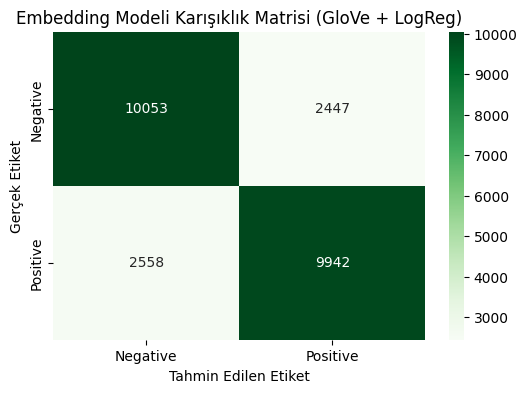


Embedding tabanlı model adımları tamamlandı.
Sonraki adım: Sonuçları Karşılaştırma ve Raporlama.


In [6]:
# --- Adım 3.3: Embedding Tabanlı Model Eğitimi (Logistic Regression) ---
print("\nEmbedding Tabanlı Model (Logistic Regression) eğitimi başlıyor...")
start_time = time.time()

# Yeni bir Logistic Regression modeli oluşturalım (baseline'dan farklı bir nesne)
# Parametreleri benzer tutabiliriz
embedding_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, solver='liblinear')

# Modeli ortalama embedding vektörleri (X_train_emb) ile eğitelim
embedding_model.fit(X_train_emb, y_train)

print(f"Embedding Tabanlı Model eğitimi tamamlandı. (Süre: {time.time() - start_time:.2f} saniye)")

# --- Adım 3.4: Embedding Tabanlı Model Değerlendirme ---
print("\nEmbedding Tabanlı Model test verisi üzerinde değerlendiriliyor...")
start_time = time.time()

# Test seti embedding vektörleri (X_test_emb) üzerinde tahmin yapalım
y_pred_embedding = embedding_model.predict(X_test_emb)

print(f"Tahminler yapıldı. (Süre: {time.time() - start_time:.2f} saniye)")

# Performans metriklerini hesaplayalım
accuracy_embedding = accuracy_score(y_test, y_pred_embedding)
report_embedding = classification_report(y_test, y_pred_embedding, target_names=['Negative', 'Positive'])
conf_matrix_embedding = confusion_matrix(y_test, y_pred_embedding)

# Sonuçları saklamak için bir sözlük oluşturalım
embedding_results = {
    "accuracy": accuracy_embedding,
    "report": report_embedding,
    "conf_matrix": conf_matrix_embedding
}

print("\n--- Embedding Tabanlı Model (Ortalama GloVe + Logistic Regression) Sonuçları ---")
print(f"Doğruluk (Accuracy): {embedding_results['accuracy']:.4f}")
print("\nSınıflandırma Raporu:")
print(embedding_results['report'])
print("\nKarışıklık Matrisi (Confusion Matrix):")

# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(embedding_results['conf_matrix'], annot=True, fmt='d', cmap='Greens', # Farklı bir renk paleti kullanalım
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Embedding Modeli Karışıklık Matrisi (GloVe + LogReg)')
plt.show()

print("\nEmbedding tabanlı model adımları tamamlandı.")
print("Sonraki adım: Sonuçları Karşılaştırma ve Raporlama.")


--- Model Karşılaştırması ---

Performans Metrikleri Karşılaştırması:
              Metric TF-IDF + LogReg Avg GloVe + LogReg
            Accuracy          0.8866             0.7998
 F1-Score (Negative)          0.8862             0.8007
 F1-Score (Positive)          0.8869             0.7989
F1-Score (Macro Avg)          0.8866             0.7998


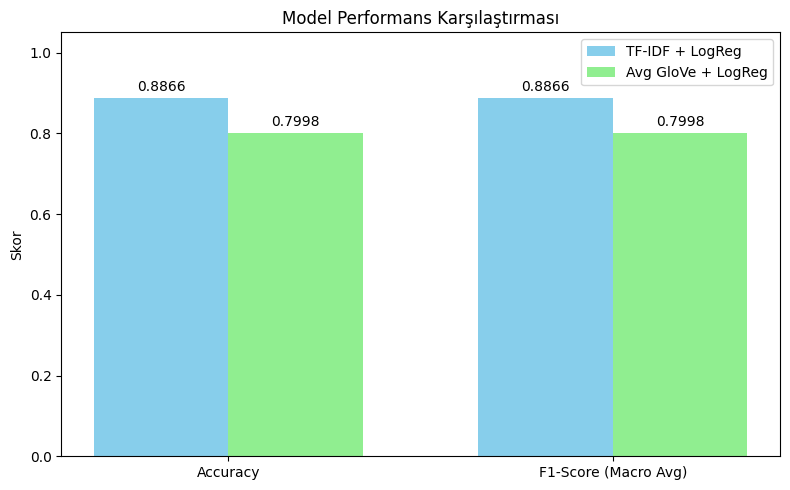


--- Yorum ve Analiz ---
TF-IDF Baseline Modeli Doğruluğu: 0.8866
Ortalama GloVe Embedding Modeli Doğruluğu: 0.7998

TF-IDF baseline modeli, Ortalama GloVe embedding yöntemine göre daha yüksek bir doğruluk elde etti.
Bunun birkaç nedeni olabilir:
- Ortalama Alma Yöntemi: Tüm kelime vektörlerinin ortalamasını almak, cümledeki önemli kelimelerin veya kelime sırasının etkisini azaltabilir.
- OOV Kelimeler: GloVe sözlüğünde bulunmayan (OOV) kelimeler için sıfır vektörü kullandık, bu da bilgi kaybına yol açmış olabilir.
- TF-IDF'nin Gücü: Bu spesifik görev ve veri seti için, kelime frekansları ve n-gram'lar (özellikle (1,2) kullandık) anlamsal bilgiden daha ayırt edici olmuş olabilir.
- Model Seçimi: Basit ortalama embedding, daha karmaşık modellerle (RNN, LSTM, CNN) kullanıldığında genellikle daha iyi performans gösterir. Logistic Regression, TF-IDF'nin yüksek boyutlu ve seyrek yapısıyla daha iyi çalışmış olabilir.

Genel Değerlendirme:
- TF-IDF, uygulaması basit ve genellikle metin sınıfl

In [7]:
# --- Adım 4: Sonuçları Karşılaştırma ---

print("\n--- Model Karşılaştırması ---")

# Metrikleri daha kolay erişilebilir hale getirelim
# Classification report'u parse etmek yerine doğrudan accuracy ve F1'e odaklanabiliriz
# Veya raporu string olarak yazdırabiliriz.

# Baseline Model Sonuçları
accuracy_base = baseline_results['accuracy']
report_base_dict = classification_report(y_test, baseline_model.predict(X_test_tfidf), target_names=['Negative', 'Positive'], output_dict=True)
f1_base_neg = report_base_dict['Negative']['f1-score']
f1_base_pos = report_base_dict['Positive']['f1-score']
f1_base_avg = report_base_dict['macro avg']['f1-score'] # veya 'weighted avg'

# Embedding Model Sonuçları
accuracy_emb = embedding_results['accuracy']
report_emb_dict = classification_report(y_test, embedding_model.predict(X_test_emb), target_names=['Negative', 'Positive'], output_dict=True)
f1_emb_neg = report_emb_dict['Negative']['f1-score']
f1_emb_pos = report_emb_dict['Positive']['f1-score']
f1_emb_avg = report_emb_dict['macro avg']['f1-score'] # veya 'weighted avg'


# Karşılaştırma için bir DataFrame oluşturalım
comparison_data = {
    'Metric': ['Accuracy', 'F1-Score (Negative)', 'F1-Score (Positive)', 'F1-Score (Macro Avg)'],
    'TF-IDF + LogReg': [f"{accuracy_base:.4f}", f"{f1_base_neg:.4f}", f"{f1_base_pos:.4f}", f"{f1_base_avg:.4f}"],
    'Avg GloVe + LogReg': [f"{accuracy_emb:.4f}", f"{f1_emb_neg:.4f}", f"{f1_emb_pos:.4f}", f"{f1_emb_avg:.4f}"]
}
df_comparison = pd.DataFrame(comparison_data)

print("\nPerformans Metrikleri Karşılaştırması:")
print(df_comparison.to_string(index=False)) # index=False daha temiz gösterir

# Karşılaştırmayı Görselleştirelim (Örn: Doğruluk ve Macro F1)
metrics_to_plot = ['Accuracy', 'F1-Score (Macro Avg)']
indices = np.arange(len(metrics_to_plot))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(indices - bar_width/2,
              [accuracy_base, f1_base_avg],
              bar_width, label='TF-IDF + LogReg', color='skyblue')
bar2 = ax.bar(indices + bar_width/2,
              [accuracy_emb, f1_emb_avg],
              bar_width, label='Avg GloVe + LogReg', color='lightgreen')

ax.set_ylabel('Skor')
ax.set_title('Model Performans Karşılaştırması')
ax.set_xticks(indices)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.bar_label(bar1, padding=3, fmt='%.4f')
ax.bar_label(bar2, padding=3, fmt='%.4f')
ax.set_ylim(0, 1.05) # Y eksenini 0 ile 1 arasında ayarla

plt.tight_layout()
plt.show()


# --- Yorum ve Analiz ---
print("\n--- Yorum ve Analiz ---")

print(f"TF-IDF Baseline Modeli Doğruluğu: {accuracy_base:.4f}")
print(f"Ortalama GloVe Embedding Modeli Doğruluğu: {accuracy_emb:.4f}\n")

if accuracy_emb > accuracy_base:
    print("Ortalama GloVe embedding yöntemi, TF-IDF yöntemine göre daha yüksek bir doğruluk elde etti.")
    print("Bu durum, embedding'lerin kelimelerin anlamsal ilişkilerini yakalayarak daha zengin bir temsil sunduğunu gösterebilir.")
    print("Özellikle TF-IDF'nin yakalayamadığı eş anlamlılık veya benzer anlamlı ifadeler embedding'ler tarafından daha iyi temsil edilmiş olabilir.")
elif accuracy_base > accuracy_emb:
    print("TF-IDF baseline modeli, Ortalama GloVe embedding yöntemine göre daha yüksek bir doğruluk elde etti.")
    print("Bunun birkaç nedeni olabilir:")
    print("- Ortalama Alma Yöntemi: Tüm kelime vektörlerinin ortalamasını almak, cümledeki önemli kelimelerin veya kelime sırasının etkisini azaltabilir.")
    print("- OOV Kelimeler: GloVe sözlüğünde bulunmayan (OOV) kelimeler için sıfır vektörü kullandık, bu da bilgi kaybına yol açmış olabilir.")
    print("- TF-IDF'nin Gücü: Bu spesifik görev ve veri seti için, kelime frekansları ve n-gram'lar (özellikle (1,2) kullandık) anlamsal bilgiden daha ayırt edici olmuş olabilir.")
    print("- Model Seçimi: Basit ortalama embedding, daha karmaşık modellerle (RNN, LSTM, CNN) kullanıldığında genellikle daha iyi performans gösterir. Logistic Regression, TF-IDF'nin yüksek boyutlu ve seyrek yapısıyla daha iyi çalışmış olabilir.")
else:
    print("Her iki model de benzer doğruluk oranları elde etti.")
    print("Bu durumda, kullanılan basit ortalama embedding yöntemi, TF-IDF kadar etkili olmuş ancak belirgin bir üstünlük sağlamamıştır.")

print("\nGenel Değerlendirme:")
print("- TF-IDF, uygulaması basit ve genellikle metin sınıflandırma görevlerinde güçlü bir başlangıç noktasıdır.")
print("- Ortalama Word Embedding, anlamsal bilgiyi yakalama potansiyeline sahiptir ancak basit ortalama alma işlemi bilgi kaybına neden olabilir.")
print("- Word embedding'lerin gerçek gücü genellikle daha gelişmiş model mimarileri (örn. derin öğrenme) ile birleştirildiğinde ortaya çıkar.")
print("- Ön işleme adımları, embedding sözlüğünün kapsamı (OOV oranı) ve ortalama dışındaki doküman vektörü oluşturma yöntemleri (örn. TF-IDF ağırlıklı ortalama) sonuçları etkileyebilir.")

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io

In [9]:
# Tokenizer oluşturma ve metinleri tokenize etme
print("\nEn sık kullanılan kelimeler için embedding'leri hazırlama...")
tokenizer = Tokenizer(num_words=5000)  # En sık kullanılan 5000 kelime
tokenizer.fit_on_texts(processed_train_reviews)

# Görselleştirme için kullanılacak kelimeler ve vektörler
word_index = tokenizer.word_index
words_to_visualize = min(5000, len(word_index))
visualization_words = []
visualization_vectors = []

for word, idx in word_index.items():
    if idx < words_to_visualize:  # Sadece en sık kullanılan kelimeleri al
        if word in embeddings_index:  # GloVe sözlüğünde varsa
            visualization_words.append(word)
            visualization_vectors.append(embeddings_index[word])

# NumPy dizisine dönüştür
visualization_vectors = np.array(visualization_vectors)
print(f"Görselleştirme için {len(visualization_words)} kelime hazırlandı.")


En sık kullanılan kelimeler için embedding'leri hazırlama...
Görselleştirme için 4972 kelime hazırlandı.


In [10]:
# Vektörleri TSV dosyasına kaydet
print("\nEmbedding vektörlerini TSV dosyalarına kaydediyor...")
vector_file = 'glove_vectors.tsv'
with open(vector_file, 'w') as f:
    for vector in visualization_vectors:
        f.write('\t'.join([str(x) for x in vector]) + "\n")

# Kelimeleri metadata dosyasına kaydet
metadata_file = 'glove_metadata.tsv'
with open(metadata_file, 'w') as f:
    for word in visualization_words:
        f.write(word + "\n")

print(f"Vektörler '{vector_file}' dosyasına kaydedildi.")
print(f"Metadata '{metadata_file}' dosyasına kaydedildi.")


Embedding vektörlerini TSV dosyalarına kaydediyor...
Vektörler 'glove_vectors.tsv' dosyasına kaydedildi.
Metadata 'glove_metadata.tsv' dosyasına kaydedildi.


In [11]:
# TensorBoard Projector için embedding layer oluşturma
embedding_var = tf.Variable(visualization_vectors, name='word_embeddings')

# Checkpoint dosyasını oluştur
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save('./embeddings/embedding.ckpt')

# Checkpoint dizininde yapılandırma dosyası oluştur
from tensorboard.plugins import projector
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = metadata_file
projector.visualize_embeddings("./embeddings", config)

print("\nTensorBoard için embedding yapılandırması tamamlandı.")
print("Yerel TensorBoard'da görüntülemek için:")
print("  tensorboard --logdir=./embeddings")


TensorBoard için embedding yapılandırması tamamlandı.
Yerel TensorBoard'da görüntülemek için:
  tensorboard --logdir=./embeddings


In [12]:
# Google Colab kullanıyorsanız, dosyaları indirmek için:
try:
    from google.colab import files
    files.download(vector_file)
    files.download(metadata_file)
    print("\nDosyaları bilgisayarınıza indirdiniz.")
    print("projector.tensorflow.org adresine gidin ve bu dosyaları yükleyin.")
except ImportError:
    print("\nBu kod yerel bir ortamda çalıştırılıyor. Oluşturulan dosyaları projector.tensorflow.org'a yükleyin.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dosyaları bilgisayarınıza indirdiniz.
projector.tensorflow.org adresine gidin ve bu dosyaları yükleyin.
